### Testing out the new project

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.clean import detect_na, standardize_columns, impute_nas
from src.eda import extended_describe, plot_correlation_heatmap, plot_dists, calc_vif, feat_select
from src.train import train_model
from src.tune import grand_tuner, param_spaces, dynamic_param_grid, save_best_params
from src.eval import eval_classification
from src.predict import load_trained_model, make_preds

from src.helper import save_best_params, load_best_params, serialize_params, stratified_sample, param_spaces, dynamic_param_grid

df = pd.read_csv('../data/Breast_Cancer.csv')
# df = pd.read_csv('../data/heart_attack_china.csv')

df

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


### Cleaning and Preprocessing

In [3]:
detect_na(df)

,Columns,NA_count
0,Age,0
1,Race,0
2,Marital Status,0
3,T Stage,0
4,N Stage,0
5,6th Stage,0
6,differentiate,0
7,Grade,0
8,A Stage,0
9,Tumor Size,0


Seems like it's pristine-- no NAs to remove

In [4]:
if df.isna().sum().sum() == 0: 
    print('No remaining NA vals')
else: 
    print('NAs detected!')

No remaining NA vals


### EDA

In [10]:
# This will kick off a much larger discussion about that OHE (One Hot Encoding) and the drop_first=True argument
# It's undeniable that some information will be lost, but it can be re-created, no? 
# Yes, they can! It's tedious, but it can be done... then what's the harm? 
# Well, when there's hundreds or thousands of features, categorical reconstruction doesn't feel as feasible! 
# Exploring this concept more in a blog post; for now we'll just use get_dummies as usual

# df_encoded = pd.get_dummies(df, dtype=int, drop_first=True)


# from src.helper import map_target_column (maybe dosen't belong here but it belongs somwehere below)

df.info()
df = standardize_columns(df)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     4024 non-null   int64 
 1   race                    4024 non-null   object
 2   marital_status          4024 non-null   object
 3   t_stage                 4024 non-null   object
 4   n_stage                 4024 non-null   object
 5   6th_stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   grade                   4024 non-null   object
 8   a_stage                 4024 non-null   object
 9   tumor_size              4024 non-null   int64 
 10  estrogen_status         4024 non-null   object
 11  progesterone_status     4024 non-null   object
 12  regional_node_examined  4024 non-null   int64 
 13  reginol_node_positive   4024 non-null   int64 
 14  survival_months         4024 non-null   int64 
 15  stat

,age,race,marital_status,t_stage,n_stage,6th_stage,differentiate,grade,a_stage,tumor_size,estrogen_status,progesterone_status,regional_node_examined,reginol_node_positive,survival_months,status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


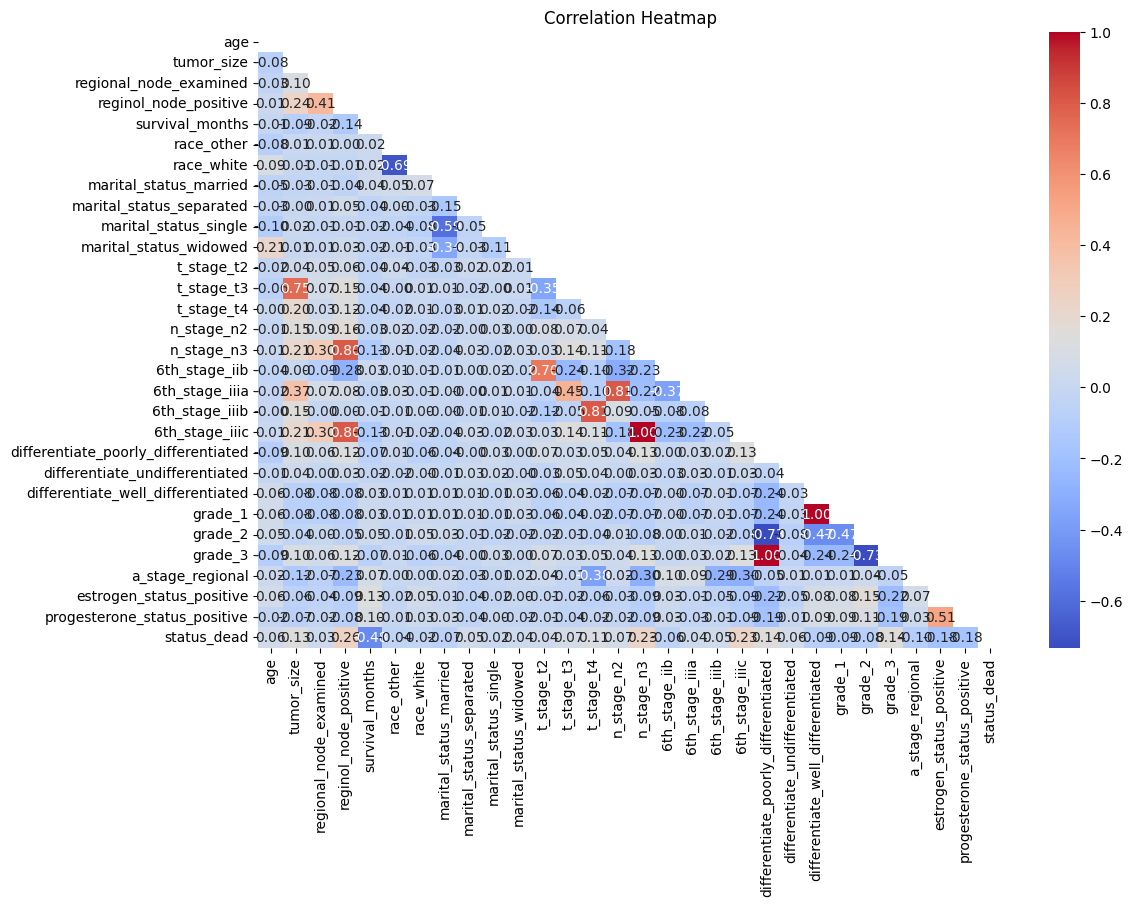

In [21]:
df_temp_enc = standardize_columns(pd.get_dummies(df, drop_first=True, dtype=int))

plot_correlation_heatmap(df_temp_enc)



In [12]:
summary_stats = extended_describe(df) 
summary_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,4024.0,53.972167,8.963134,30.0,47.0,54.0,61.0,69.0,-0.220373,-0.755088
tumor_size,4024.0,30.473658,21.119696,1.0,16.0,25.0,38.0,140.0,1.739750,3.634207
regional_node_examined,4024.0,14.357107,8.099675,1.0,9.0,14.0,19.0,61.0,0.829274,1.649322
reginol_node_positive,4024.0,4.158052,5.109331,1.0,1.0,2.0,5.0,46.0,2.702536,8.981266
survival_months,4024.0,71.297962,22.921430,1.0,56.0,73.0,90.0,107.0,-0.589998,0.019977


In [13]:
calc_vif(df)

,Feature,VIF
0,age,11.165060
1,tumor_size,3.076264
2,regional_node_examined,4.741349
3,reginol_node_positive,2.139799
4,survival_months,8.732301


`age` is the only feature that appears to be outside the 'safe' range (10+) for VIF. Seems that investigation is required here.

In [18]:

df_temp_enc.groupby('status_dead')['tumor_size'].mean()

status_dead
0    29.268779
1    37.139610
Name: tumor_size, dtype: float64

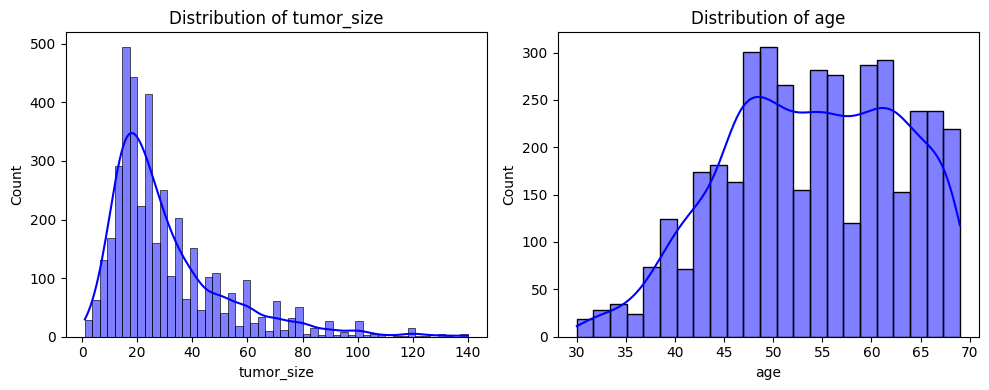

In [19]:
plot_dists(df, ['tumor_size', 'age'])

## Randomized Search --> GridSearch
Similar concept to using a Mixture Model to find optimal centroids, then plugging those same centroids into KMeans, which will run 100x faster. 

1. RandomizedSearchCV-- explores a broad parameter space without testing every single combination. It's the advance troops, narrowing down the scope  

2. GridSearchCV-- Focuses on the most promising regions found in step 1, fine-tuning the best params

## TESTING THE GRAND TUNER

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# rf_model = RandomForestClassifier(class_weight='balanced', random_state=10)

# # Pass None to use default grid from param_spaces
# best_model, best_params, cv_results = grand_tuner(
#     model=rf_model,
#     param_grid=None,  # Uses default
#     X=X,
#     y=y,
#     cv=2,  # Start small
#     scoring='roc_auc',
#     use_smote=True,
#     n_iter=2  # Start small, scale later
# )

# ================================
# Folded into tune_and_train_full()-- updated 03/27/25


Starting Grand Tuner with 2-fold Cross-Validation...
Model: RandomForestClassifier
Scoring metric: roc_auc
SMOTE Enabled: True
Running RandomizedSearchCV with 2 iterations...
Using default param grid for RandomForestClassifier: {'classifier__n_estimators': [50, 100, 200, 300, 500], 'classifier__max_depth': [None, 10, 20, 30, 50], 'classifier__min_samples_split': [2, 5, 10, 20], 'classifier__min_samples_leaf': [1, 2, 5, 10], 'classifier__max_features': ['sqrt', 'log2', None]}
Fitting 2 folds for each of 2 candidates, totalling 4 fits
⏱️ RandomizedSearchCV completed in 22.18 minutes

🎲 Best Parameters from RandomizedSearch: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': None, 'classifier__max_depth': 50}
🛠️ Running GridSearchCV with refined parameters: {'classifier__n_estimators': [450, 500, 550], 'classifier__max_depth': [40, 50, 60]}
Fitting 2 folds for each of 9 candidates, totalling 18 fits
⏱️ Grid

# Now Testing `tune_and_train_full()`

In [ ]:
# from src.helper import map_target_column


# df['status'] = map_target_column(df, 'status', 
#                                        positive='Alive', 
#                                        negative='Dead')  

# df['status']

AttributeError: Can only use .str accessor with string values!

### DATA LEAKAGE FIX ONGOING
1. Split raw data 
2. Fit new encoder on X_train_raw -- transform both train and test
3. Run `feat_select` on encoded X_train 
4. Apply selected features to both X_train and X_test. 

In [ ]:
# # Testing here: 
# from imblearn.over_sampling import SMOTE
# from sklearn.discriminant_analysis import StandardScaler
# from sklearn.linear_model import ElasticNetCV
# from sklearn.model_selection import StratifiedKFold


# def feat_select(df_encoded: pd.DataFrame, target, smote_enabled=True, imbal_thresh=0.15):
#     '''
#     Feature selection using ElasticNetCV on an encoded (quickly with get_dummies) df

#     Returns: 
#         selected: List of selected feature names
#     '''

#     X = df_encoded.drop(columns=[target])
#     y = df_encoded[target]

#     # Check for imbalance
#     class_counts = y.value_counts(normalize=True) 
#     min_class_ratio = class_counts.min()

#     if smote_enabled and min_class_ratio < imbal_thresh: 
#         print(f"⚠️ Imbalanced data detected ({min_class_ratio:.2%}). Applying SMOTE...\n")
#         X, y = SMOTE(random_state=10).fit_resample(X, y) 

#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X) 

#     min_alpha = 1e-7 * abs((X_scaled.T @ y)).mean()

#     elastic_model = ElasticNetCV(
#         alphas = pd.Series(np.geomspace(min_alpha, min_alpha*100, 50)), 
#         l1_ratio=0.6 if smote_enabled else [0.1, 0.5, 0.9],
#         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10),
#         random_state=10
#         ) 
    
#     elastic_model.fit(X_scaled, y)

#     selected = X.columns[elastic_model.coef_ != 0].tolist()

#     print("📌 ElasticNet Feature Selection Summary")
#     print("======================================")
#     print(f"SMOTE enabled: {smote_enabled}")
#     print(f"Selected feature count: {len(selected)} (🔻{X.shape[1] - len(selected)} trimmed)")
#     print(f"Best Alpha: {elastic_model.alpha_:.2e}")
#     print(f"Best L1 Ratio: {elastic_model.l1_ratio_:.2f}")
#     print("======================================\n")

#     return selected

# ------------------------
# Folded into eda.py in /src

In [26]:
selected_feats = feat_select(df_temp_enc, 'status_dead', True)

📌 ElasticNet Feature Selection Summary
SMOTE enabled: True
Selected feature count: 27 (🔻2 trimmed)
Best Alpha: 1.58e-03
Best L1 Ratio: 0.60



In [27]:
selected_feats

['age',
 'regional_node_examined',
 'reginol_node_positive',
 'survival_months',
 'race_other',
 'race_white',
 'marital_status_married',
 'marital_status_separated',
 'marital_status_single',
 'marital_status_widowed',
 't_stage_t2',
 't_stage_t3',
 't_stage_t4',
 'n_stage_n2',
 'n_stage_n3',
 '6th_stage_iib',
 '6th_stage_iiia',
 '6th_stage_iiib',
 '6th_stage_iiic',
 'differentiate_poorly_differentiated',
 'differentiate_undifferentiated',
 'differentiate_well_differentiated',
 'grade_1',
 'grade_3',
 'a_stage_regional',
 'estrogen_status_positive',
 'progesterone_status_positive']

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# # Step 1: Split BEFORE encoding!
X = df.drop(columns=['status'])
y = df['status']

# --- First split: train_val and test
X_temp, X_test_raw, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=10) 

# --- Second split: train and val 
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=10)

# X_train_raw, X_test_raw, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=10) 

# Step 2: Fit OHE only on training!
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train_raw) 
X_val_encoded = ohe.transform(X_val_raw) # transform, *not* fit_transform!
X_test_encoded = ohe.transform(X_test_raw) # transform, *not* fit_transform!

# Now back to DataFrames with col names: 
encoded_cols = ohe.get_feature_names_out(X_train_raw.columns) 

X_train = pd.DataFrame(X_train_encoded, columns=encoded_cols)
X_val = pd.DataFrame(X_val_encoded, columns=encoded_cols) 
X_test = pd.DataFrame(X_test_encoded, columns=encoded_cols)


# Comment / uncomment for testing if this actually helps
# ======================================================
# X_train = X_train[selected_feats]
# X_val = X_val[selected_feats] 
# X_test = X_test[selected_feats]


c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9, 12, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [9, 12, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from src.run_pipeline import tune_and_train_full


logit_model, best_params = tune_and_train_full(
    model_class=RandomForestClassifier,
    model_name='RandomForest',
    X_train=X_train,
    y_train=y_train,
    # model_params={'class_weight': 'balanced'},
    # model_params = None,
    X_test=X_test,
    y_test=y_test,
    sample_frac=0.2, 
    scoring='roc_auc',
    use_smote=True,
    n_iter=20, 
    cv=5,
    dev_mode=False 
)

🔍 Sampled 482 rows (20.0%)
Class distribution:
status
1    408
0     74

Starting Grand Tuner | CV: 5 | Scoring: roc_auc
Model: RandomForestClassifier | SMOTE: True | Random Iterations: 20

**RandomForestClassifier param grid is None, using default

Fitting 5 folds for each of 20 candidates, totalling 100 fits
⏱️ RandomizedSearchCV completed in 0.17 minutes

Fitting 5 folds for each of 9 candidates, totalling 45 fits
⏱️ GridSearchCV completed in 0.09 minutes

🏆 Best Hyperparameters: {
  "classifier__n_estimators": 250,
  "classifier__min_samples_split": 5,
  "classifier__min_samples_leaf": 1,
  "classifier__max_features": "log2",
  "classifier__max_depth": null
}

📊 Best roc_auc: 0.7616
💾 Saved best params for RandomForestClassifier to ../tuned_params\RandomForestClassifier_best_params.json


[TRAINING] Starting model training...

→ Training RandomForest with params:
{
    "classifier__n_estimators": 250,
    "classifier__min_samples_split": 5,
    "classifier__min_samples_leaf": 1,
  

## Plotting Threshold Curves

Helper Function, here temporarily.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from collections import Counter

def find_best_threshold(y_true, y_probs, metric='f1', plot=True):
    '''
    Finds optimal classification thresh for a given metric (defauly f1)

    Args: 
        y_true: Ground truth binary labels
        y_probs: Predicted probs for target class
        metric: f1 
        plot: Whether to plot the metric vs thresh curve

    Returns: 
        best_thresh: Thresh that maximizes f1
    '''

    thresholds = np.linspace(0.0, 1.0, 100)
    scores = []

    # Determining minority class:
    class_counts = Counter(y_true)
    minority_class = min(class_counts, key=class_counts.get) 

    for t in thresholds: 
        y_pred = (y_probs >= t).astype(int) 
        score = f1_score(y_true, y_pred, pos_label=minority_class, average='binary', zero_division=0) 
        scores.append(score)

    best_idx = np.argmax(scores)
    best_thresh = thresholds[best_idx]

    # Warn if threshold is extremely low or high
    if best_thresh < 0.05 or best_thresh > 0.95:
        print(f"⚠️ Warning: Best threshold is at extreme value: {best_thresh:.3f}. Check model calibration.")

    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(thresholds, scores, label=f'{metric} score') 
        plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best threshold = {best_thresh:.2f}')
        plt.xlabel('Threshold') 
        plt.ylabel(f'{metric.upper()} Score')
        plt.title(f'{metric.upper()} vs Threshold')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.show() 

    return best_thresh

Once tested, getting sent to `eval.py` -- remember to copy this version over! Also remember to get all the imports ready!!!

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score

# from src.eval import find_best_threshold 

# Potting the Threshold Curves
def plot_threshold_curves(y_true, y_probs, model_name='Model', highlight_threshold=0.25, save_path=None, auto_find_best=True, metric='f1'):
    '''
    Plots the ROC and Precision-Recall curves with optional annotations

    Args: 
        y_true: Ground truth binary labels
        y_probs: Predicted probs of the positive class
        model_name: Name of the model (used for labels!)
        highlight_threshold: Optional thresh to annotate on both curves
        save_path: Optional filepath to save the plots
        auto_find_best: if True, auto finds the best thresh based on chosen metric
        metric: Metric to optimize (f1 or recall) 

    Returns: 
        threshold_to_plot: The thresh tht was highlighted (auto or manual) 
    '''

    # Decide which thresh to highlight
    if auto_find_best: 
        highlight_threshold = find_best_threshold(y_true, y_probs, metric=metric, plot=True)

    # Roc Data
    # fpr -- False Positive Rate 
    # tpr -- True Positive Rate
    # roc_thresholds -- differing threshs used to generated fpr, tpr pairs :D 

    # auc(fpr, tpr) calcs total area under the ROC curve.
    # This is the model's ability to discriminate between classes

    # Reminder: Area Under Curve (AUC) 
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr) 

    # PR Data
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)

    # Find closest index to thresh_to_plot
    idx_roc = np.argmin(np.abs(roc_thresholds - highlight_threshold))
    idx_pr = np.argmin(np.abs(pr_thresholds - highlight_threshold)) 

    # Plot
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

    # ROC Curve
    ax1.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    ax1.plot([0,1], [0,1], linestyle='--', color='gray') # Represents random classification (FPR = TPR)
    ax1.scatter(fpr[idx_roc], tpr[idx_roc], color='red', label=f'Thresh = {round(highlight_threshold, 3)}')
    ax1.set_title(f'ROC Curve - {model_name}')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Raet') 
    ax1.legend()

    ax2.plot(recall, precision, label=f'AUC = {pr_auc:.2f}') 
    ax2.scatter(recall[idx_pr], precision[idx_pr], color='red', label=f'Thresh = {round(highlight_threshold, 3)}')
    ax2.set_title(f'Precision-Recall Curve - {model_name}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision') 
    ax2.legend()

    fig.suptitle(f"Threshold Analysis for {model_name}", fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f'Plot saved to {save_path}')
    
    plt.show() 
    
    return round(highlight_threshold, 3)


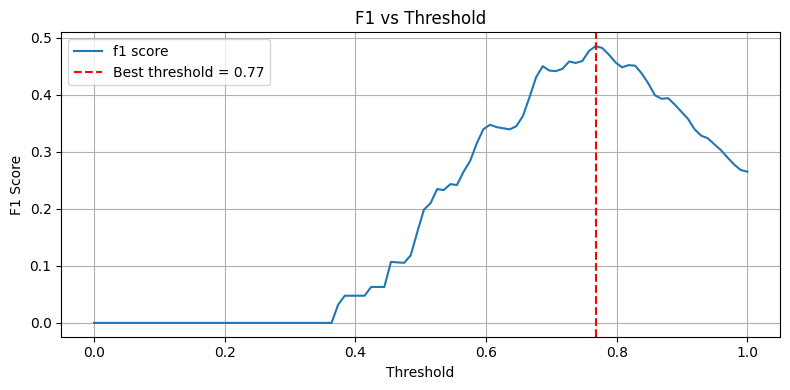

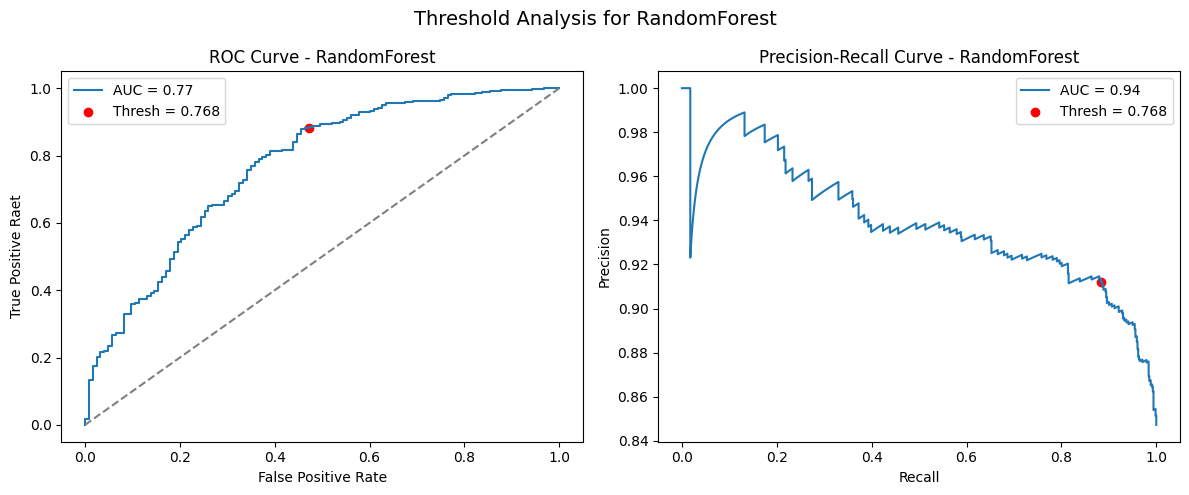

np.float64(0.768)

In [34]:
# from src.eval import plot_threshold_curves

y_probs_rf = logit_model.predict_proba(X_test)[:,1] 
# y_probs_logit = .predict_proba(X_test)[:,1]

# Plotting ROC and PR Curves:
plot_threshold_curves(y_test, y_probs_rf, "RandomForest", auto_find_best=True)

Testing `eval_classification` with the new thresh (which we just found) 

In [35]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss


def calibrate_model(model, X_val, y_val, method='sigmoid', cv=None):
    '''
    Calibrates a classifier's predicted probs using CalibratedClassifierCV

    Args: 
        model: already fitted classifier 
        X_calib: feats for calibration
        y_calib: target lables for calibration
        method: calibration method ('sigmoid' or 'isotonic')
        cv = number of cv folds or None (means prefit)

    Returns: 
        calibrated_model: Calibrated classifier with predict_proba support
    '''

    if cv == 'prefit':
        calibrated_model = CalibratedClassifierCV(estimator=model, method=method, cv=None)
        calibrated_model.fit(X_val, y_val)
    else: 
        calibrated_model = CalibratedClassifierCV(estimator=model, method=method, cv=5)
        calibrated_model.fit(X_val, y_val)
    
    print(f"✅ Model calibrated using {method} method")
    return calibrated_model

def compare_probs(model, calibrated_model, X_val, y_val): 
    '''
    Compares predicted probs before and after model calibration

    Also displays predicted prob dist from before and after calibration
    '''
    # First get probs
    pre_probs = model.predict_proba(X_val)[:,1]
    post_probs = calibrate_model.predict_proba(X_val)[:,1]

    # Summaries
    print("\n📊 Probability Summary — Before Calibration:")
    print(pd.Series(pre_probs).describe())

    print("\n📊 Probability Summary — After Calibration:")
    print(pd.Series(post_probs).describe())

    print(f"\n🔍 Log Loss Before: {log_loss(y_val, pre_probs):.4f}")
    print(f"🔍 Log Loss After : {log_loss(y_val, post_probs):.4f}")

    # Plot the dists
    plt.hist(pre_probs, bins=30, alpha=0.5, label='Before Calibration')
    plt.hist(post_probs, bins=30, alpha=0.5, label='After Calibration')
    plt.title('Predicted Probability Distribution (Class 1)')
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()


In [36]:
calibrated_model = calibrate_model(logit_model, X_val, y_val, cv='prefit')

✅ Model calibrated using sigmoid method


In [37]:
eval_classification(calibrated_model, X_test, y_test, threshold=0.25)


🔧 Custom threshold applied: 0.25

Evaluating Model: CalibratedClassifierCV
Hyperparameters:
{
    "cv": null,
    "ensemble": "auto",
    "estimator__memory": null,
    "estimator__steps": "[('scaler', StandardScaler()), ('model', RandomForestClassifier(max_features='log2', min_samples_split=5,\n                       n_estimators=250))]",
    "estimator__transform_input": null,
    "estimator__verbose": false,
    "estimator__scaler": "StandardScaler()",
    "estimator__model": "RandomForestClassifier(max_features='log2', min_samples_split=5,\n                       n_estimators=250)",
    "estimator__scaler__copy": true,
    "estimator__scaler__with_mean": true,
    "estimator__scaler__with_std": true,
    "estimator__model__bootstrap": true,
    "estimator__model__ccp_alpha": 0.0,
    "estimator__model__class_weight": null,
    "estimator__model__criterion": "gini",
    "estimator__model__max_depth": null,
    "estimator__model__max_features": "log2",
    "estimator__model__max_lea

In [38]:
def compare_class_means(df: pd.DataFrame, target: str):
    '''
    Compares mean values across classes and returns top differentiators 

    Args: 
        df: Input dataframe
        target (str): Name of target column

    Returns:
        top_diff (df): Top differentiating features by mean difference
    '''

    grouped_means = df.groupby(target).mean().T
    grouped_means['diff'] = abs(grouped_means[0] - grouped_means[1]) 
    top_diff = grouped_means.sort_values(by='diff', ascending=False).head(10)

    print(f'\nTop Differentiating Features (mean diff):')
    print(top_diff[['diff']])
    return top_diff

In [39]:
from sklearn.feature_selection import mutual_info_classif

def compute_mutual_info(df: pd.DataFrame, target: str):
    ''' 
    Calculates mutual information scores between features and target
    MI captures non-linear relationships 
    Scores that are close to 0 across the board indicate problems

    Args: 
        df: Input dataframe
        target (str): Name of target col

    Returns: 
        mi_series (pd.Series): Mutual info scores
    '''

    X = df.drop(columns=target)
    y = df[target]

    mi = mutual_info_classif(X, y, discrete_features='auto', random_state=10)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

    print(f'\nMutual Information Scores:')
    print(mi_series.head(10))

    return mi_series

In [41]:
compute_mutual_info(df_temp_enc, 'status_dead')


Mutual Information Scores:
survival_months                        0.139107
reginol_node_positive                  0.029019
6th_stage_iiic                         0.026939
n_stage_n3                             0.025491
progesterone_status_positive           0.020695
grade_3                                0.012602
t_stage_t4                             0.012171
grade_2                                0.010110
estrogen_status_positive               0.009455
differentiate_poorly_differentiated    0.008370
dtype: float64


survival_months                        0.139107
reginol_node_positive                  0.029019
6th_stage_iiic                         0.026939
n_stage_n3                             0.025491
progesterone_status_positive           0.020695
grade_3                                0.012602
t_stage_t4                             0.012171
grade_2                                0.010110
estrogen_status_positive               0.009455
differentiate_poorly_differentiated    0.008370
marital_status_separated               0.006357
t_stage_t3                             0.005563
race_white                             0.003421
grade_1                                0.002838
age                                    0.002711
6th_stage_iiib                         0.002515
6th_stage_iib                          0.001437
tumor_size                             0.001216
differentiate_well_differentiated      0.001125
t_stage_t2                             0.000585
regional_node_examined                 0